## 3. 기계학습

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### 1) 분류문제

In [2]:
# 데이터 로드
df = pd.read_csv('./data/hotel_bookings.csv')

# 데이터 전처리 
# lead_time 결측치 삭제
df1 = df.dropna(axis=0, subset='lead_time')

# is_repeated_guest 변수는 이진형 변수이기 때문에 최빈값으로 대체
df1['is_repeated_guest'] = df1['is_repeated_guest'].fillna(0)

# adr 변수 deposit_type 별 평균 adr로 대체

df1= df1.groupby('deposit_type').apply(lambda x: x.fillna(x.mean()))
df1 = df1.reset_index().drop(columns='index')

df1.isna().sum()

is_canceled                       0
deposit_type                      0
lead_time                         0
stays_in_weekend_nights           0
stays_in_week_nights              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
booking_changes                   0
days_in_waiting_list              0
adr                               0
dtype: int64

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19995 entries, 0 to 19994
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     19995 non-null  int64  
 1   deposit_type                    19995 non-null  object 
 2   lead_time                       19995 non-null  float64
 3   stays_in_weekend_nights         19995 non-null  int64  
 4   stays_in_week_nights            19995 non-null  int64  
 5   is_repeated_guest               19995 non-null  float64
 6   previous_cancellations          19995 non-null  int64  
 7   previous_bookings_not_canceled  19995 non-null  int64  
 8   booking_changes                 19995 non-null  int64  
 9   days_in_waiting_list            19995 non-null  int64  
 10  adr                             19995 non-null  float64
dtypes: float64(3), int64(7), object(1)
memory usage: 1.7+ MB


In [4]:
df1.adr.unique()

array([131.5      ,  73.95     , 101.9658274, ..., 185.85     ,
       242.75     ,  79.62     ])

In [5]:
X = df1.drop(columns='is_canceled')
y = df1['is_canceled']

# 스케일링 전에 범주형 변수와 수치형 변수 분리
# 스케일링은 수치형 변수만!!!
cat_features = X.select_dtypes(include=['object']).columns.to_list()
num_features = X.select_dtypes(exclude='object').columns.to_list()

# PowerTransformer를 사용한 스케일링
from sklearn.preprocessing import PowerTransformer
X[num_features] = PowerTransformer(standardize=True).fit_transform(X[num_features])
X = pd.concat([X[num_features], pd.get_dummies(X[cat_features])], axis=1)

# 데이터 불균형 처리
from imblearn.over_sampling import SMOTE
# SMOTE
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X,y)

# 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm,stratify=y_sm, test_size=0.3, random_state=1)

### (1) 로지스틱 회귀

혼동행렬: [[4318  960]
 [2168 3111]]
Accuracy: 0.7037037037037037
roc_auc:  0.7037145399622619


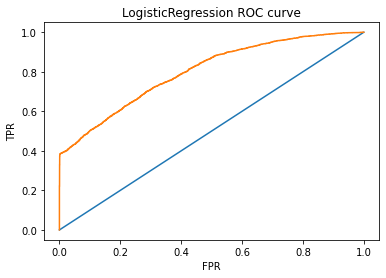

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

# 모델 생성 및 학습
clf = LogisticRegression() # 다항분류일 때, multi_class='multinomial'로 해주면 됨
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print('혼동행렬:', confusion_matrix(y_test,y_pred))
print("Accuracy:", accuracy)
print("roc_auc: ",roc_auc_score(y_test, y_pred))

# ROC_AUC 시각화
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test,clf.predict_proba(X_test)[:,1])
plt.plot([0,1], [0,1])
plt.plot(fpr, tpr, label='clf')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('LogisticRegression ROC curve')
plt.show()

In [7]:
clf.predict_proba(X_test)

array([[0.02059758, 0.97940242],
       [0.46756734, 0.53243266],
       [0.5881765 , 0.4118235 ],
       ...,
       [0.7239213 , 0.2760787 ],
       [0.75281242, 0.24718758],
       [0.00631574, 0.99368426]])

### (2) 서포트 백터 머신

In [8]:
y_pred

array([1, 1, 0, ..., 0, 0, 1], dtype=int64)

혼동행렬: [[4535  743]
 [2302 2977]]
Accuracy: 0.7115657857345837
roc_auc:  0.7115797714510246


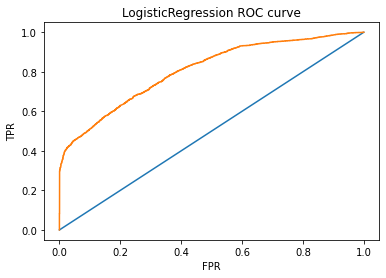

In [9]:
from sklearn.svm import SVC

# 모델 생성 및 학습
clf = SVC(C=0.5,probability=True) # probability= False면 predict_proba 안됨 default는 False로 설정됐기 때문에 True로 바꿔줘야됨
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print('혼동행렬:', confusion_matrix(y_test,y_pred))
print("Accuracy:", accuracy)
print("roc_auc: ",roc_auc_score(y_test, y_pred))

# ROC_AUC 시각화
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test,clf.predict_proba(X_test)[:,1])
plt.plot([0,1], [0,1])
plt.plot(fpr, tpr, label='clf')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('LogisticRegression ROC curve')
plt.show()

### (3) KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# 모델 생성 및 학습
clf = KNeighborsClassifier(n_neighbors=10, weights='uniform') 
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print('혼동행렬:', confusion_matrix(y_test,y_pred))
print("Accuracy:", accuracy)
print("roc_auc: ",roc_auc_score(y_test, y_pred))


혼동행렬: [[4256 1022]
 [ 950 4329]]
Accuracy: 0.8132045088566827
roc_auc:  0.8132038611524668


### (4) Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier

# 모델 생성 및 학습
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print('혼동행렬:', confusion_matrix(y_test,y_pred))
print("Accuracy:", accuracy)
print("roc_auc: ",roc_auc_score(y_test, y_pred))



혼동행렬: [[3619 1659]
 [1414 3865]]
Accuracy: 0.7089135170976604
roc_auc:  0.7089113161955459


In [12]:
# 변수중요도 확인

importance = clf.feature_importances_
columns_nm = pd.DataFrame(X.columns)
feature_importance = pd.concat([columns_nm,pd.DataFrame(importance)],axis=1)

feature_importance.columns = ['feature_nm', 'importances']

feature_importance

,feature_nm,importances
0,lead_time,0.184836
1,stays_in_weekend_nights,0.000736
2,stays_in_week_nights,0.000000
3,is_repeated_guest,0.000080
4,previous_cancellations,0.064629
5,previous_bookings_not_canceled,0.006697
6,booking_changes,0.076879
7,days_in_waiting_list,0.000000
8,adr,0.027670
9,deposit_type_No Deposit,0.626315


### (5) Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

# 모델 생성 및 학습
clf = RandomForestClassifier(n_estimators=100, min_samples_split=5)
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print('혼동행렬:', confusion_matrix(y_test,y_pred))
print("Accuracy:", accuracy)
print("roc_auc: ",roc_auc_score(y_test, y_pred))

# ROC_AUC 시각화
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt



혼동행렬: [[4725  553]
 [ 695 4584]]
Accuracy: 0.8817845978971298
roc_auc:  0.8817858709475461


In [14]:
# 변수중요도 확인

importance = clf.feature_importances_
columns_nm = pd.DataFrame(X.columns)
feature_importance = pd.concat([columns_nm,pd.DataFrame(importance)],axis=1)

feature_importance.columns = ['feature_nm', 'importances']

feature_importance

,feature_nm,importances
0,lead_time,0.313593
1,stays_in_weekend_nights,0.037592
2,stays_in_week_nights,0.077704
3,is_repeated_guest,0.003609
4,previous_cancellations,0.032980
5,previous_bookings_not_canceled,0.010162
6,booking_changes,0.051946
7,days_in_waiting_list,0.003330
8,adr,0.276169
9,deposit_type_No Deposit,0.091118


### (6) AdaBoost

In [15]:
from sklearn.ensemble import AdaBoostClassifier

# 모델 생성
clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.5)
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print('혼동행렬:', confusion_matrix(y_test,y_pred))
print("Accuracy:", accuracy)
print("roc_auc: ",roc_auc_score(y_test, y_pred))



혼동행렬: [[3992 1286]
 [1467 3812]]
Accuracy: 0.7392251586624988
roc_auc:  0.7392267803657108


### (7) XGB

In [16]:
from xgboost import XGBClassifier

# 모델 생성
clf = XGBClassifier(n_estimators=100, learning_rate=0.5)
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print('혼동행렬:', confusion_matrix(y_test,y_pred))
print("Accuracy:", accuracy)
print("roc_auc: ",roc_auc_score(y_test, y_pred))



혼동행렬: [[4897  381]
 [ 618 4661]]
Accuracy: 0.9053708439897699
roc_auc:  0.9053729696500991


### (8) LGBM

In [17]:
# !pip install lightgbm
from lightgbm import LGBMClassifier

# 모델 생성
clf = LGBMClassifier(n_estimators=100, learning_rate=0.5)
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print('혼동행렬:', confusion_matrix(y_test,y_pred))
print("Accuracy:", accuracy)
print("roc_auc: ",roc_auc_score(y_test, y_pred))


혼동행렬: [[4626  652]
 [ 728 4551]]
Accuracy: 0.869281045751634
roc_auc:  0.8692817264973696


### (9) MLP

혼동행렬: [[4492  786]
 [1683 3596]]
Accuracy: 0.7661267405512929
roc_auc:  0.7661347868871499


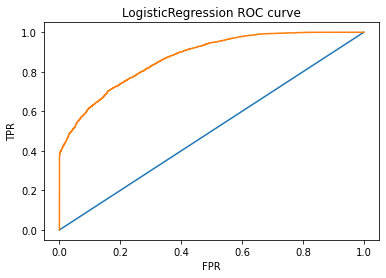

In [18]:
from sklearn.neural_network import MLPClassifier

# 모델 생성 
clf = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', learning_rate_init=0.001, alpha=0.0001)
clf.fit(X_train, y_train)
y_pred= clf.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print('혼동행렬:', confusion_matrix(y_test,y_pred))
print("Accuracy:", accuracy)
print("roc_auc: ",roc_auc_score(y_test, y_pred))

# ROC_AUC 시각화
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test,clf.predict_proba(X_test)[:,1])
plt.plot([0,1], [0,1])
plt.plot(fpr, tpr, label='clf')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('LogisticRegression ROC curve')
plt.show()

### (10) 앙상블

In [19]:
# Voting을 진행할 때 predict_proba가 오류가 나지 않게 probability=True로 바꿔줘야 된다
# 이는 각 모델마다 설정해야되는게 있고 필요없는 것도 있음
from sklearn.ensemble import VotingClassifier

# 모델 생성 

rf = RandomForestClassifier(n_estimators=100, min_samples_split=5)
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', learning_rate_init=0.001, alpha=0.0001)
lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.5)

# 보팅 앙상블 생성 (하드 보팅)
voting_clf_hard = VotingClassifier(estimators=[('rf', rf), ('mlp', mlp), ('lgbm', lgbm)], voting='hard')

# 보팅 앙상블 생성 (소프트 보팅)
voting_clf_soft = VotingClassifier(estimators=[('rf', rf), ('mlp', mlp), ('lgbm', lgbm)], voting='soft')

# 보팅 앙상블 모델 학습
voting_clf_hard.fit(X_train, y_train)
voting_clf_soft.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred_hard = voting_clf_hard.predict(X_test)
y_pred_soft = voting_clf_soft.predict(X_test)

# 정확도 평가
accuracy_hard = accuracy_score(y_test, y_pred_hard)
accuracy_soft = accuracy_score(y_test, y_pred_soft)
roc_auc_hard = roc_auc_score(y_test,y_pred_hard)
roc_auc_soft = roc_auc_score(y_test,y_pred_soft)
print("Hard Voting Accuracy:", accuracy_hard)
print("Soft Voting Accuracy:", accuracy_soft)
print("Hard Voting Roc_Auc:", roc_auc_hard)
print("Soft Voting Roc_Auc:", roc_auc_soft)

Hard Voting Accuracy: 0.8704177323103154
Soft Voting Accuracy: 0.8819740456569101
Hard Voting Roc_Auc: 0.8704186284089739
Soft Voting Roc_Auc: 0.8819738651456387


### (11) Stacking

In [20]:
from sklearn.ensemble import StackingClassifier

# 기본 모델들 생성
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, min_samples_split=5)),
    ('knn', KNeighborsClassifier(n_neighbors=10, weights='uniform')),
    ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.5))
]

# 메타 모델 생성 
# 기본 모델 중에 겹치는 모델이 있어도 괜찮음
# 대신 하이퍼파라미터가 겹치지 않게 조절하는 것이 좋음
meta_model = LogisticRegression()

# 스태킹 모델 생성
stacking_model = StackingClassifier(estimators=estimators, final_estimator=meta_model)

# 스태킹 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred = stacking_model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# roc_acu 평가
roc_auc = roc_auc_score(y_test, y_pred)
print("roc_auc_score:", roc_auc)

Accuracy: 0.9146537842190016
roc_auc_score: 0.9146540974946956


### (12) 그리드 서치

In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(n_estimators=1000)

param_grid = [{'max_depth':[2,4,6,8,10]}]

grid_xgb = GridSearchCV(xgb, param_grid=param_grid, scoring='roc_auc', 
                                     cv=3, n_jobs=-1)
grid_xgb.fit(X_train,y_train)
print('final params', grid_xgb.best_params_)   # 최적의 파라미터 값 출력
print('Train data best score', grid_xgb.best_score_)   # 최고의 점수

# 테스트 데이터 평가
y_pred = grid_xgb.predict(X_test)
print('Test data roc_auc: ',roc_auc_score(y_test,y_pred))
print('Test data Accuracy: ',accuracy_score(y_test,y_pred))

final params {'max_depth': 4}
Train data best score 0.9632466495363726
Test data roc_auc:  0.9317068724692296
Test data Accuracy:  0.9317040825992232


### (13) 랜덤그리드 서치

In [22]:
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier(n_estimators=1000)

param_grid = [{'max_depth':[2,4,6,8,10]}]

randomgrid_xgb = RandomizedSearchCV(xgb, param_distributions=param_grid, scoring='roc_auc', 
                                   cv=3, n_iter=3, n_jobs=-1)

grid_xgb.fit(X_train,y_train)
print('final params', grid_xgb.best_params_)   # 최적의 파라미터 값 출력
print('Train data best score', grid_xgb.best_score_)   # 최고의 점수

# 테스트 데이터 평가
y_pred = grid_xgb.predict(X_test)
print('Test data roc_auc: ',roc_auc_score(y_test,y_pred))
print('Test data Accuracy: ',accuracy_score(y_test,y_pred))

final params {'max_depth': 4}
Train data best score 0.9632466495363726
Test data roc_auc:  0.9317068724692296
Test data Accuracy:  0.9317040825992232


### (14) Cross-validation

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

np.random.seed(0)

clf = RandomForestClassifier(n_estimators=100, min_samples_split=5)

score_k_fold = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv = KFold(n_splits=5, shuffle=True,))
print('scroe_k_fold:', score_k_fold)
print('k-fold:', np.mean(score_k_fold))


scroe_k_fold: [0.87050944 0.87639537 0.86969758 0.87677629 0.86967113]
k-fold: 0.8726099633619583
